<a href="https://colab.research.google.com/github/DiggsPapu/Proyecto_NLP/blob/main/Proyecto_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocesamiento del Corpus

### Descarga de dataset

In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np

import unicodedata

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import TweetTokenizer

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
path = kagglehub.dataset_download("philipsanm/sentiment-analysis-in-spanish-tweets")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sentiment-analysis-in-spanish-tweets' dataset.
Path to dataset files: /kaggle/input/sentiment-analysis-in-spanish-tweets


In [5]:
# Find the CSV file in the dataset directory
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
dataset_file = os.path.join(path, csv_files[0])

# Load the dataset into a DataFrame
df = pd.read_csv(dataset_file)
df.head()

,user,text,date,emotion,sentiment
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed,scared
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed,scared
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed,scared
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed,scared


### Stats del corpus


*   El corpus debe de tener al menos 2000 documentos
*   El corpus debe de ser en español



In [6]:
assert df.shape[0]>=2000, "No tiene la mínima cantidad de documentos"

### Limpiar

In [7]:
# Tokenizar tweets
tknzr = TweetTokenizer()
def remover_tildes(word):
    normalized_word = unicodedata.normalize('NFD', word)
    word_without_tildes = ''.join(char for char in normalized_word if not unicodedata.combining(char))
    return word_without_tildes

def limpiar_texto(text):
    text = tknzr.tokenize(text)
    stop_words = set(stopwords.words('spanish'))
    return [remover_tildes(word.lower()) for word in text if word not in stop_words]

In [8]:
df['tokenized'] = df['text'].apply(lambda text: limpiar_texto(text))
df.head(1)

,user,text,date,emotion,sentiment,tokenized
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared,"[termine, bien, abrumado, despues, hoy]"


### Lemmatization with spacy
La idea es que haga toda la lemmatización con spacy dado que no hay solución nativa con nltk para español

In [9]:
!python -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 22.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
!pip install spacy-lookups-data


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.4 MB/s eta 0:00:00


In [11]:
# ___CONFIGURAR EL PIPELINE PARA LEMMATIZER___
# Este modelo realiza este pipeline ['tok2vec', 'morphologizer', 'parser', 'senter', 'attribute_ruler', 'lemmatizer', 'ner']
# nlp = spacy.load("es_core_news_md")
# El problema con quitar alguno de estos para el pipeline es que no realiza la lemmatizacion correctamente dado que provee embeddings contextuales para la lemmatizacion
import spacy
nlp = spacy.load("es_core_news_md")
def apply_lemmatization(word):
  doc = nlp(word)
  token = doc[0]
  # print(token.text, token.lemma_, token.pos_, token.morph)
  return doc[0].lemma_

In [12]:
apply_lemmatization("corremos")

'corrar'

In [13]:
df['tokenized'] = df['tokenized'].apply(lambda text: [apply_lemmatization(word) for word in text])
df.head(1)

,user,text,date,emotion,sentiment,tokenized
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared,"[terminar, bien, abrumado, despues, hoy]"


### Algoritmo de levenshtein

In [14]:
!pip install levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 89.3 MB/s eta 0:00:00


In [15]:
df['tokenized_joined'] = df['tokenized'].apply(lambda text: ' '.join(text))
df.head(1)

,user,text,date,emotion,sentiment,tokenized,tokenized_joined
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared,"[terminar, bien, abrumado, despues, hoy]",terminar bien abrumado despues hoy


In [16]:
from Levenshtein import distance as lev_dist

lev_dist("lewenstein", "levenshtein")

2

In [17]:
def calculate_levenshtein_distance(text1, text2):
    return lev_dist(text1, text2)

In [18]:
df['levenshtein_mean'] = 0
df['levenshtein_mean_cleaned_text'] = 0

#### Promedio Levenshtein con texto crudo
Es para averiguar que tanto varía del texto limpio contra el texto sin limpiar

In [19]:
# Number of tweets
n = df.shape[0]

# Initialize distance matrix
distance_matrix = np.zeros((n, n))

# Compute upper triangle only (i < j)
for i in range(n):
    for j in range(i + 1, n):
        dist = calculate_levenshtein_distance(df.at[i, 'text'], df.at[j, 'text'])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist  # Symmetric

# Compute mean distance per tweet (excluding self-comparison)
df['levenshtein_mean'] = distance_matrix.sum(axis=1) / (n - 1)


#### Promedio Levenshtein con texto Limpio
Es para averiguar que tanto varía del texto limpio contra el texto sin limpiar

In [20]:
# Number of tweets
n = df.shape[0]

# Initialize distance matrix
distance_matrix = np.zeros((n, n))

# Compute upper triangle only (i < j)
for i in range(n):
    for j in range(i + 1, n):
        dist = calculate_levenshtein_distance(df.at[i, 'tokenized_joined'], df.at[j, 'tokenized_joined'])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist  # Symmetric

# Compute mean distance per tweet (excluding self-comparison)
df['levenshtein_mean_cleaned_text'] = distance_matrix.sum(axis=1) / (n - 1)


#### Top 20 tweets
Estos son los 20 tweets que requieren una menor cantidad en promedio de cambios para poder asemejarse a otros. En promedio una distancia Levenshtein menor.
El primero es con los textos limpios, el segundo es con el texto crudo

In [21]:
df.sort_values(by='levenshtein_mean_cleaned_text',ascending=True)[['tokenized_joined', 'levenshtein_mean_cleaned_text']][:20]

,tokenized_joined,levenshtein_mean_cleaned_text
785,"creer aun ser reservado cosa , poder ser salir .",80.127076
860,el ultimo ano medio ser laberinto desorientador .,80.516416
1290,estar parolo decir llevar buen rato pie . 🤣,80.771727
1477,"creer aceptar , 27 ano , persona necesitar amor .",81.011587
1502,el sirenita poder ser negra pint blanco negro,81.018154
926,por cierto actitud dar contar seguir soltero,81.075319
896,que eliane erin triste caso aislado .,81.081885
766,que eliane erin triste caso aislado .,81.081885
130,"« cuanto abatido , amado , decir san bernardo » .",81.100039
1130,"« cuanto abatido , amado , decir san bernardo » .",81.100039


In [22]:
df.sort_values(by='levenshtein_mean',ascending=True)[['text', 'levenshtein_mean']][:20]

,text,levenshtein_mean
2456,Porqué sigo esperanzado en el amor cunado se q...,109.768250
1425,quiero que sepas que no se va el amor que te t...,109.903051
1502,La sirenita puede ser negra pero no pintes a u...,109.964851
594,"La verdad es que estoy desilusionado, ya no le...",110.082657
2507,si nunca te dijieron que el auto esta re atrev...,110.088065
279,Ando en celo ¿o como es que se dice cuando uno...,110.234840
490,los regalos se abren a estas horas pq a impaci...,110.331016
319,No le hagan comentarios a la gente ansiosa por...,110.392430
816,"Me caga q se tarde en contestar, pero sabe q a...",110.417922
781,Entre más reservado seas mejor te va a ir en l...,110.430282


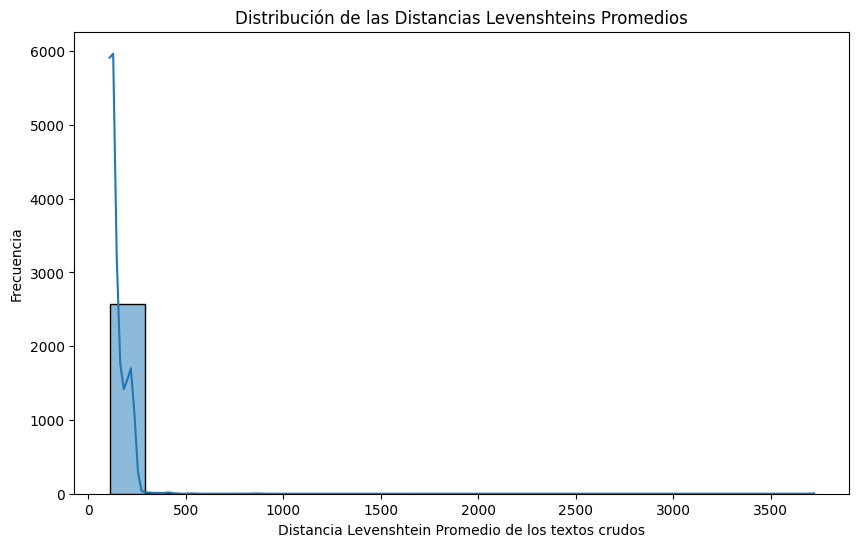

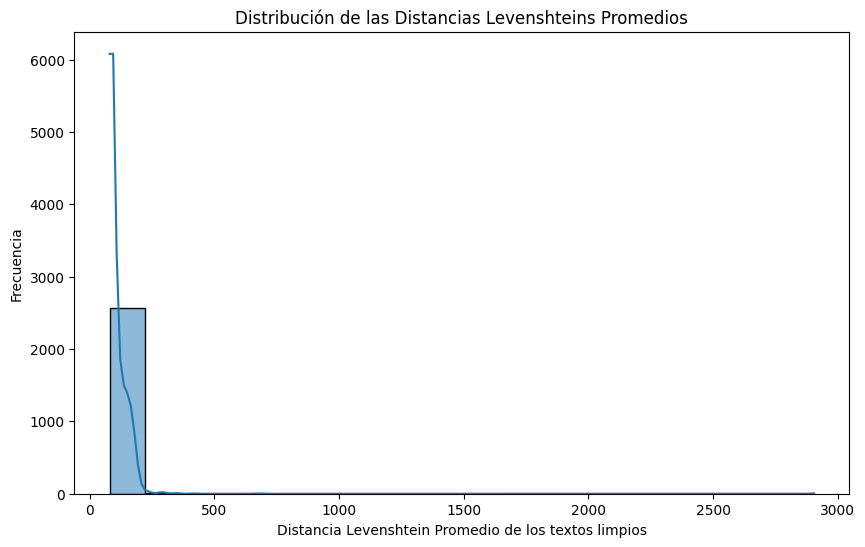

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df['levenshtein_mean'], bins=20, kde=True)
plt.xlabel('Distancia Levenshtein Promedio de los textos crudos')
plt.ylabel('Frecuencia')
plt.title('Distribución de las Distancias Levenshteins Promedios')
plt.show()
plt.figure(figsize=(10, 6))
sns.histplot(df['levenshtein_mean_cleaned_text'], bins=20, kde=True)
plt.xlabel('Distancia Levenshtein Promedio de los textos limpios')
plt.ylabel('Frecuencia')
plt.title('Distribución de las Distancias Levenshteins Promedios')
plt.show()

Lo que demuestra que en realidad la mayoría de tweets suelen tener una distancia promedio levenshtein de menores de 250 en el caso de los textos limpios.
Además, se denota que existe una diferencia de cuándo está normalizado contra los que no están normalizados, por ejemplo, el top de 20 tweets varía, también aumenta la media de levenshtein tal cómo se observan en los top tweets con menor distancia promedio.

## Representación del Texto

### BoW vs TF-IDF

#### BoW

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df['tokenized_joined'])

print(vectorizer.get_feature_names_out())

print(X_bow.shape)

['00' '000' '01' ... '𝐥𝐢𝐛𝐞𝐫𝐚𝐫𝐞𝐦𝐨𝐬' '𝐩𝐞𝐫𝐬𝐨𝐧𝐚𝐣𝐞' '𝗮𝗹𝗴𝘂𝗶𝗲𝗻']
(2590, 7990)


#### TF-IDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['tokenized_joined'])

print(tfidf_vectorizer.get_feature_names_out())

print(X_tfidf.shape)

['00' '000' '01' ... '𝐥𝐢𝐛𝐞𝐫𝐚𝐫𝐞𝐦𝐨𝐬' '𝐩𝐞𝐫𝐬𝐨𝐧𝐚𝐣𝐞' '𝗮𝗹𝗴𝘂𝗶𝗲𝗻']
(2590, 7990)


In [26]:
X_bow.T.shape

(7990, 2590)

### Matriz de Co ocurrencia
Funciona la multiplicación de la matriz de las BoW.T[7990,2590]\*BoW[2590,7990] generando una matriz [7990,7900]. Sin embargo, es una matriz binaria, ya que de esta forma lo único que cuenta es si la palabra aparece en el documento o no. Al momento de realizar la multiplicación de matrices entre la transpuesta y la matriz original se obtiene para cada [i,j] la cantidad de documentos que aparecen ambos dado que para cada multiplicación se puede obtener 1\*1, 1\*0 o 0\*1.

El problema con esta aplicación es el hecho de que no captura correctamente la coocurrencia local, es decir si realmente existe una probabilidad de que si se encuentra una palabra exista la otra como en gramas.

In [27]:
vocabulary = tfidf_vectorizer.vocabulary_
X_bow_c = (X_bow>0).astype(int)
X_cooccurrence = (X_bow_c.T * X_bow_c)

X_cooccurrence.setdiag(0)

print("Co-occurrence matrix shape:", X_cooccurrence.shape)

print(X_cooccurrence.todense()[:2])
df_coocurrence = pd.DataFrame(X_cooccurrence.todense(), columns=tfidf_vectorizer.get_feature_names_out())
print(df_coocurrence.head())

Co-occurrence matrix shape: (7990, 7990)
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
   00  000  01  05  09  0hs  0s  10  100  1000  ...  ún  ᅠᅠᅠ  ㅋㅋㅋ  ㅤse  \
0   0    0   1   0   0    0   0   0    0     0  ...   0    0    1    0   
1   0    0   0   0   0    0   0   0    0     0  ...   0    0    0    0   
2   1    0   0   0   0    0   0   0    0     0  ...   0    0    0    0   
3   0    0   0   0   0    0   0   0    0     0  ...   0    0    0    0   
4   0    0   0   0   0    0   0   0    0     0  ...   0    0    0    0   

   𝐏𝐫𝐞𝐫𝐫𝐞𝐬𝐞𝐫𝐯𝐚𝐬  𝐝𝐢𝐬𝐩𝐨𝐧𝐢𝐛𝐥𝐞  𝐞𝐥  𝐥𝐢𝐛𝐞𝐫𝐚𝐫𝐞𝐦𝐨𝐬  𝐩𝐞𝐫𝐬𝐨𝐧𝐚𝐣𝐞  𝗮𝗹𝗴𝘂𝗶𝗲𝗻  
0             0           0   0            0          0        0  
1             0           0   0            0          0        0  
2             0           0   0            0          0        0  
3             0           0   0            0          0        0  
4             0           0   0            0          0        0  

[5 rows x 7990 columns]


Por eso es que se utilizó este código ya que a partir de la ventana se logra deducir si un conjunto de 4 palabras están relacionados

In [31]:
from collections import Counter
def build_vocab(tokenized_docs,min_freq:int =1):
  counts = Counter([t for doc in tokenized_docs for t in doc])
  vocab = [w for w, c in counts.items() if c>= min_freq ]
  vocab = sorted(vocab)
  word2idx = {w:i for i,w in enumerate(vocab)}
  idx2word = {i:w for i,w in enumerate(vocab)}
  return vocab, word2idx, idx2word,counts

def sliding_windows_indices(center, windows_size,n):
  start = max(0,center-windows_size)
  end = min(n,center+windows_size+1)
  return [i for i in range(start,end) if i !=center]
tokenized_docs = df['tokenized']
vocab,word2idx,idx2word,counts = build_vocab(tokenized_docs,min_freq=1)
def build_cooccurrence(tokenized_docs,word2idx,windows_size=2):
  V = len(word2idx)
  M = np.zeros((V,V),dtype=float)
  for doc in tokenized_docs:
    n=len(doc)
    for i,w in enumerate(doc):
      wi = word2idx[w]
      for j in sliding_windows_indices(i,windows_size,n):
        cj = word2idx[doc[j]]
        M[wi,cj]+=1.0
  return M
print('Docs:',len(tokenized_docs))
print('Vocab size: ',len(vocab))
print('Top-10: ',Counter([t for d in tokenized_docs for t in d]).most_common(10))
WINDOW = 2
C=build_cooccurrence(tokenized_docs,word2idx,windows_size=WINDOW)
cooc_df= pd.DataFrame(C,index=vocab,columns=vocab)
cooc_df
cooc_df.iloc[:15,:15]

Docs: 2590
Vocab size:  8534
Top-10:  [(',', 2724), ('.', 2229), ('el', 414), ('ser', 413), ('?', 387), ('"', 362), ('hacer', 326), ('si', 304), ('#', 297), ('ir', 245)]


,!,"""",#,$,%,&,',(,),):,*,+,",",-,--
!,214.0,0.0,8.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,16.0,3.0,0.0
"""",0.0,92.0,7.0,0.0,0.0,0.0,1.0,3.0,2.0,1.0,2.0,0.0,32.0,22.0,0.0
#,8.0,7.0,180.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,10.0,2.0,0.0
$,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
&,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
',2.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
(,0.0,3.0,0.0,0.0,4.0,0.0,0.0,2.0,55.0,0.0,0.0,1.0,13.0,0.0,0.0
),0.0,2.0,4.0,0.0,4.0,0.0,0.0,55.0,8.0,0.0,0.0,0.0,21.0,4.0,0.0
):,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Positive Pointwise Mutual Information (PPMI)

In [32]:
def ppmi(C,eps=1e-12):
  total =float(C.sum())+eps
  Pwc = C/total
  Pw = Pwc.sum(axis=1,keepdims=True)
  Pc = Pwc.sum(axis=0,keepdims=True)
  PMI= np.log((Pwc+eps)/ (Pw @ Pc+ eps))
  return np.maximum(PMI,0.0)

PPMI = ppmi(C)
ppmi_df = pd.DataFrame(PPMI,index=vocab,columns=vocab)
ppmi_df.iloc[:15,:15]

,!,"""",#,$,%,&,',(,),):,*,+,",",-,--
!,4.178206,0.000000,0.767247,0.000000,0.000000,0.000000,1.426493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.642374,0.0
"""",0.000000,2.196935,0.065174,0.000000,0.000000,0.000000,0.164804,0.000000,0.000000,2.046175,0.766979,0.000000,0.000000,2.066262,0.0
#,0.767247,0.065174,3.756338,1.255548,0.000000,0.000000,0.000000,0.000000,0.393426,0.000000,0.000000,2.301050,0.000000,0.112484,0.0
$,0.000000,0.000000,1.255548,5.739467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.314159,3.404046,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
&,0.000000,0.000000,0.000000,0.000000,0.000000,7.665041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
',1.426493,0.164804,0.000000,0.000000,0.000000,0.000000,4.957044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
(,0.000000,0.000000,0.000000,0.000000,3.314159,0.000000,0.000000,0.000000,3.368329,0.000000,0.000000,1.556302,0.000000,0.000000,0.0
),0.000000,0.000000,0.393426,0.000000,3.404046,0.000000,0.000000,3.368329,1.530323,0.000000,0.000000,0.000000,0.000000,1.249382,0.0
):,0.000000,2.046175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
